In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

# --- New SDE Parameters ---
alpha_new = 1/8
beta_new = 1/32
gamma_new = 1/20
X0_new = 1/10

# Ensure seed is set for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# SDE Configuration (keeping N, T, etc. consistent for comparison)
T = 1.0           # terminal time
N = 100           # time steps
dt = T / N
sqrt_dt = np.sqrt(dt)
n_traj = 1000      # number of trajectories
batch_size = 64
epochs = 200
lr = 1e-3

t_grid = np.linspace(0, T, N+1)

print(f"New SDE: dX_t = ({alpha_new}*X_t + {beta_new}*X_t^2)dt + {gamma_new}*X_t dW_t")
print(f"Initial Condition X_0 = {X0_new}")

Using device: cpu
New SDE: dX_t = (0.125*X_t + 0.03125*X_t^2)dt + 0.05*X_t dW_t
Initial Condition X_0 = 0.1


In [ ]:
# ---------------------------------
# Data generation for the new SDE
# ---------------------------------
def simulate_custom_sde(n_traj, x0):
    X = np.zeros((n_traj, N+1), dtype=np.float32)
    dW = np.zeros((n_traj, N), dtype=np.float32)
    X[:,0] = x0
    for i in range(N):
        dW_i = np.random.normal(loc=0.0, scale=sqrt_dt, size=n_traj).astype(np.float32)
        dW[:,i] = dW_i
        # Custom SDE drift and diffusion
        drift_val = alpha_new * X[:,i] + beta_new * (X[:,i]**2)
        diff_val = gamma_new * X[:,i]
        X[:,i+1] = X[:,i] + drift_val * dt + diff_val * dW_i
    return X, dW

X_data_new, dW_data_new = simulate_custom_sde(n_traj, X0_new)
X_data_t_new = torch.tensor(X_data_new, dtype=torch.get_default_dtype(), device=device)
dW_data_t_new = torch.tensor(dW_data_new, dtype=torch.get_default_dtype(), device=device)

print(f"Generated {n_traj} trajectories for the new SDE.")

Generated 1000 trajectories for the new SDE.


In [ ]:
# Re-defining MLP for clarity, though it's already in kf04WZvzsmdB
# It's good practice to ensure dependencies are clear in new sections.
class MLP(nn.Module):
    def __init__(self, in_dim, out_dim, hidden=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden),
            nn.Tanh(),
            nn.Linear(hidden, hidden),
            nn.Tanh(),
            nn.Linear(hidden, out_dim)
        )
    def forward(self, x):
        return self.net(x)

# Re-initialize models for the new SDE problem
drift_net_new = MLP(2, 1, hidden=64).to(device)
diffusion_net_new = MLP(2, 1, hidden=64).to(device)

params_new = list(drift_net_new.parameters()) + list(diffusion_net_new.parameters())
optimizer_new = optim.Adam(params_new, lr=lr)
mse_loss_new = nn.MSELoss()

print("Neural networks re-initialized for the new SDE.")

Neural networks re-initialized for the new SDE.


In [ ]:
# -----------------------------------------------------
# Helper: one Euler step with the *new* network models
# -----------------------------------------------------
def network_step_new(x, t_scalar):
    if x.dim() == 0:
        x = x.unsqueeze(0)
    inp = torch.stack([x, torch.full_like(x, float(t_scalar))], dim=-1)
    drift = drift_net_new(inp).squeeze(-1)
    diff = diffusion_net_new(inp).squeeze(-1)
    diff = torch.nn.functional.softplus(diff)  # ensure positivity
    return drift, diff

In [ ]:
# ---------------------------------
# Training loop for the new SDE
# ---------------------------------
n_batches = n_traj // batch_size
loss_history_new = []

print("Starting training for the new SDE...")
for epoch in range(1, epochs+1):
    perm = torch.randperm(n_traj, device=device)
    epoch_loss = 0.0
    for b in range(n_batches):
        idx = perm[b*batch_size:(b+1)*batch_size]
        X_batch = X_data_t_new[idx]   # (B, N+1)
        dW_batch = dW_data_t_new[idx] # (B, N)

        # Forward: build prediction and loss using same dW increments
        x_pred = X_batch[:,0]  # (B,)
        total_loss = 0.0
        for i in range(N):
            t_now = float(t_grid[i])
            drift_pred, diff_pred = network_step_new(x_pred, t_now)
            x_next_pred = x_pred + drift_pred * dt + diff_pred * dW_batch[:,i]
            x_next_true = X_batch[:, i+1]
            total_loss = total_loss + mse_loss_new(x_next_pred, x_next_true)
            x_pred = x_next_pred

        optimizer_new.zero_grad()
        total_loss.backward()
        optimizer_new.step()
        epoch_loss += total_loss.item()
    epoch_loss = epoch_loss / n_batches
    loss_history_new.append(epoch_loss)
    if epoch % 10 == 0 or epoch == 1:
        print(f"Epoch {epoch}/{epochs}, loss = {epoch_loss:.6f}")

print("Training finished for the new SDE.")

Starting training for the new SDE...
Epoch 1/200, loss = 7.841063
Epoch 10/200, loss = 0.029605
Epoch 20/200, loss = 0.008449
Epoch 30/200, loss = 0.003659
Epoch 40/200, loss = 0.001967
Epoch 50/200, loss = 0.001211
Epoch 60/200, loss = 0.000805
Epoch 70/200, loss = 0.000587
Epoch 80/200, loss = 0.000452
Epoch 90/200, loss = 0.000373
Epoch 100/200, loss = 0.000320
Epoch 110/200, loss = 0.000295
Epoch 120/200, loss = 0.000266
Epoch 130/200, loss = 0.000255
Epoch 140/200, loss = 0.000251
Epoch 150/200, loss = 0.000243
Epoch 160/200, loss = 0.000237
Epoch 170/200, loss = 0.000228
Epoch 180/200, loss = 0.000227
Epoch 190/200, loss = 0.000235
Epoch 200/200, loss = 0.000219
Training finished for the new SDE.


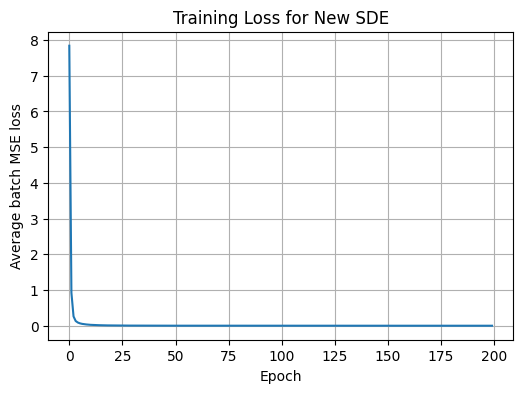

In [ ]:
# ---------------------------------
# Plot loss for the new SDE
# ---------------------------------
plt.figure(figsize=(6,4))
plt.plot(loss_history_new)
plt.xlabel("Epoch")
plt.ylabel("Average batch MSE loss")
plt.title("Training Loss for New SDE")
plt.grid(True)
plt.show()

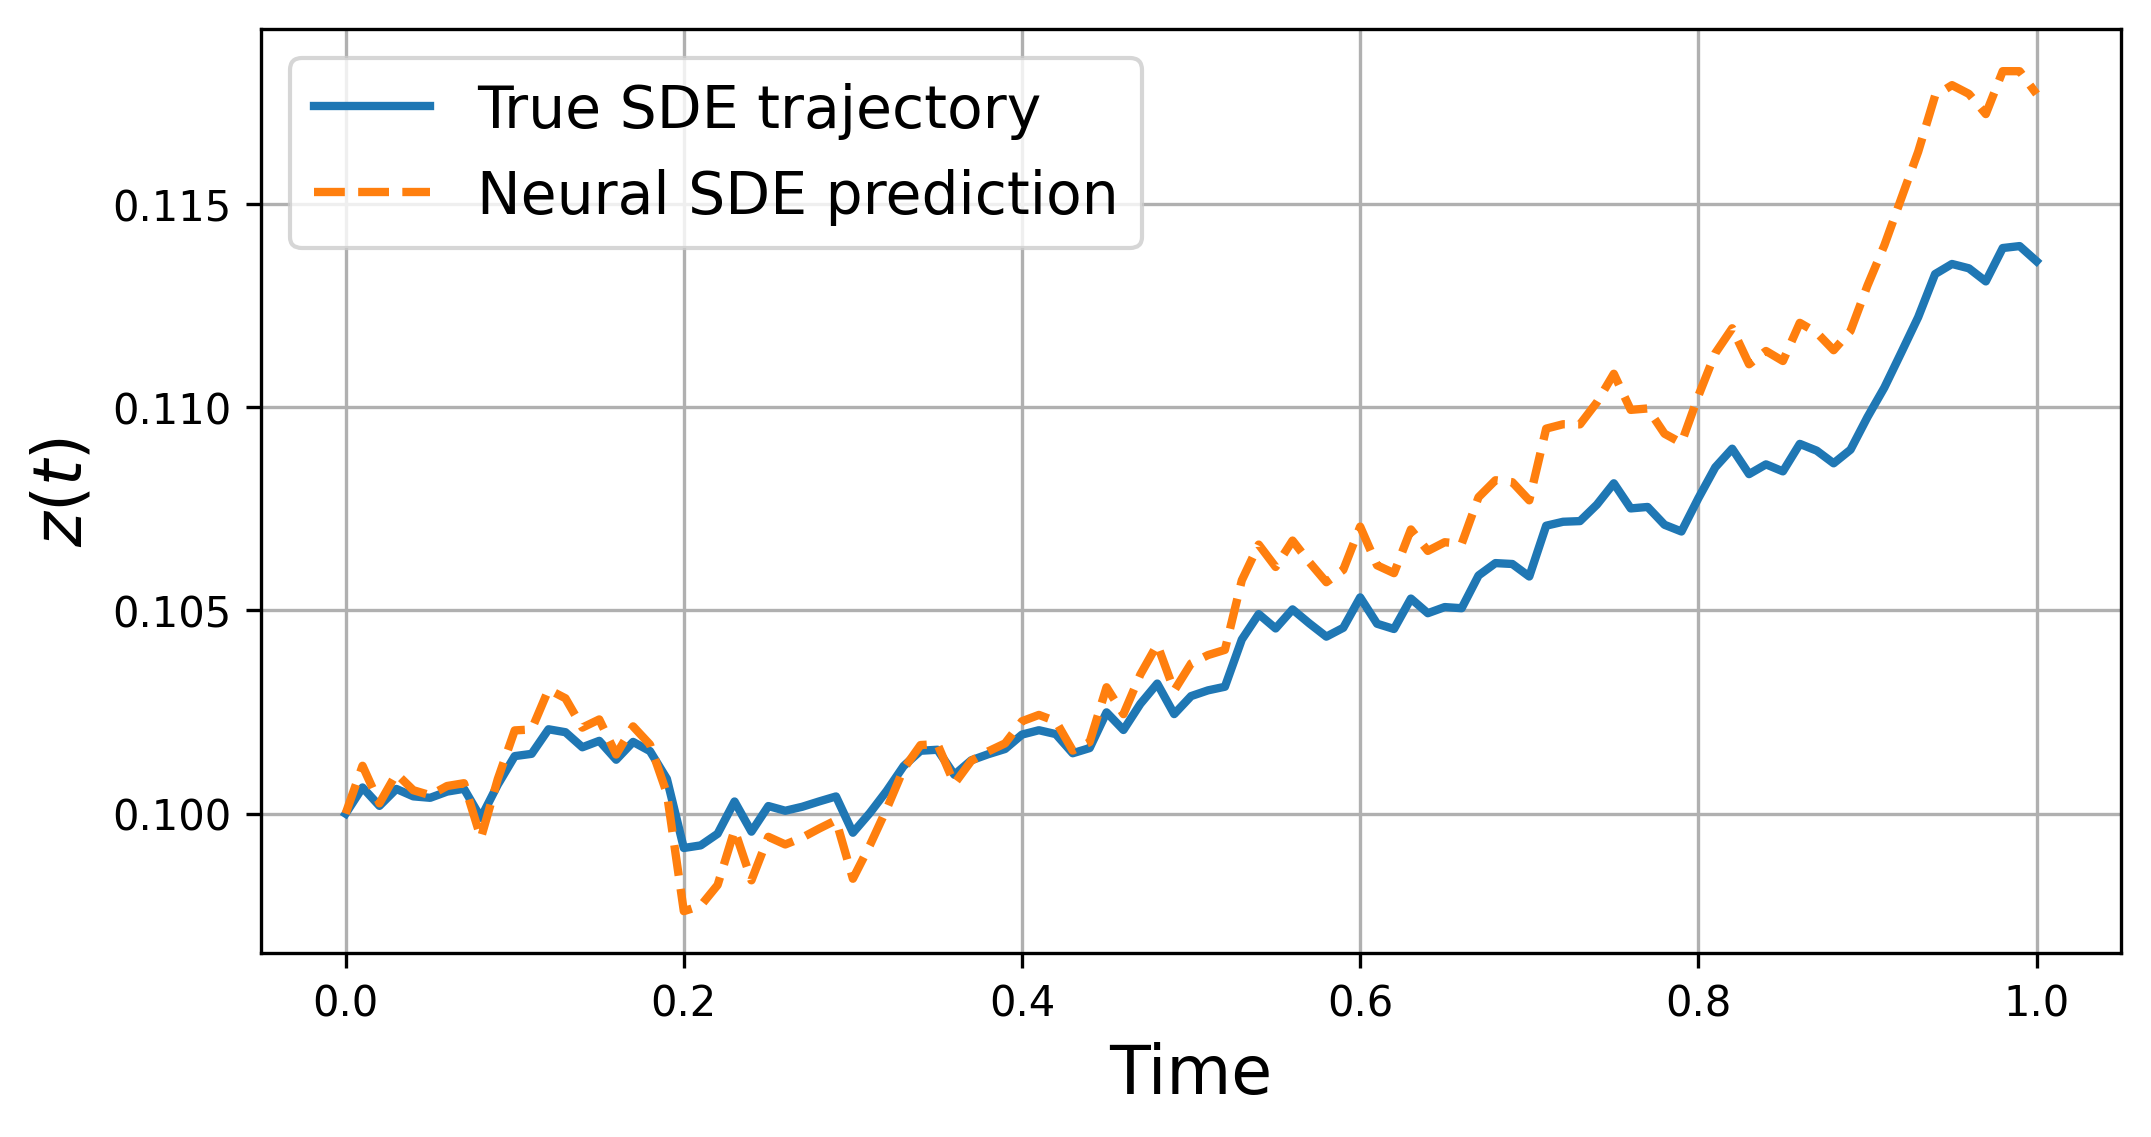

In [ ]:
# -----------------------------------------------------
# Evaluate on one new sample path for the new SDE
# -----------------------------------------------------
with torch.no_grad():
    x_true_sde = np.zeros(N+1, dtype=np.float32)
    x_true_sde[0] = X0_new
    dW_sample_sde = np.random.normal(scale=sqrt_dt, size=N).astype(np.float32)
    for i in range(N):
        # True SDE step
        drift_true = alpha_new * x_true_sde[i] + beta_new * (x_true_sde[i]**2)
        diff_true = gamma_new * x_true_sde[i]
        x_true_sde[i+1] = x_true_sde[i] + drift_true * dt + diff_true * dW_sample_sde[i]

    x_model_sde = np.zeros(N+1, dtype=np.float32)
    x_model_sde[0] = X0_new
    x_torch_sde = torch.tensor(X0_new, dtype=torch.get_default_dtype(), device=device).unsqueeze(0)
    for i in range(N):
        t_now = float(t_grid[i])
        drift_pred, diff_pred = network_step_new(x_torch_sde, t_now)
        dW_i = torch.tensor(dW_sample_sde[i], dtype=torch.get_default_dtype(), device=device).unsqueeze(0)
        x_next = x_torch_sde + drift_pred * dt + diff_pred * dW_i
        x_model_sde[i+1] = x_next.item()
        x_torch_sde = x_next

plt.figure(figsize=(8,4), dpi=300)
plt.plot(t_grid, x_true_sde, label="True SDE trajectory", linewidth=2)
plt.plot(t_grid, x_model_sde, label="Neural SDE prediction", linewidth=2, linestyle="--")
plt.xlabel("Time", fontsize = 16)
plt.ylabel("$z(t)$", fontsize = 16)
plt.legend(fontsize = 14)
#plt.title("True vs Neural SDE (Custom Equation)")
plt.grid(True)
plt.show()

In [ ]:
# -----------------------------------------------------
# Print sample learned drift/diffusion for the new SDE
# -----------------------------------------------------
xs_sde = torch.linspace(0.01, 1.0, 9, device=device) # Adjust range based on expected X_t values for the new SDE
print("\nLearned drift/diffusion at t=0 for sample x's (New SDE):")
with torch.no_grad():
    for xi in xs_sde:
        d, s = network_step_new(xi.unsqueeze(0), 0.0)
        # Compare with true values
        true_drift = alpha_new * xi + beta_new * (xi**2)
        true_diff = gamma_new * xi
        print(f"x={xi.item():.4f} -> Learned drift={d.item():.4f} (True={true_drift.item():.4f}), Learned diffusion={s.item():.4f} (True={true_diff.item():.4f})")

# Save weights for the new SDE model
torch.save(drift_net_new.state_dict(), "drift_net_new_sde.pth")
torch.save(diffusion_net_new.state_dict(), "diffusion_net_new_sde.pth")
print("\nSaved new model weights to current directory (drift_net_new_sde.pth, diffusion_net_new_sde.pth)")


Learned drift/diffusion at t=0 for sample x's (New SDE):
x=0.0100 -> Learned drift=0.1842 (True=0.0013), Learned diffusion=0.0100 (True=0.0005)
x=0.1338 -> Learned drift=-0.0426 (True=0.0173), Learned diffusion=0.0094 (True=0.0067)
x=0.2575 -> Learned drift=-0.2687 (True=0.0343), Learned diffusion=0.0090 (True=0.0129)
x=0.3812 -> Learned drift=-0.4903 (True=0.0522), Learned diffusion=0.0087 (True=0.0191)
x=0.5050 -> Learned drift=-0.7046 (True=0.0711), Learned diffusion=0.0085 (True=0.0253)
x=0.6287 -> Learned drift=-0.9087 (True=0.0909), Learned diffusion=0.0085 (True=0.0314)
x=0.7525 -> Learned drift=-1.1008 (True=0.1118), Learned diffusion=0.0086 (True=0.0376)
x=0.8763 -> Learned drift=-1.2796 (True=0.1335), Learned diffusion=0.0088 (True=0.0438)
x=1.0000 -> Learned drift=-1.4443 (True=0.1562), Learned diffusion=0.0090 (True=0.0500)

Saved new model weights to current directory (drift_net_new_sde.pth, diffusion_net_new_sde.pth)
